In [39]:
import xarray as xr
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings("ignore")
import numpy as np 

minlat = 32 #36
minlon = -140 #160


dirread = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'

def getclosest_ij(lats,lons,latpt,lonpt):     
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2                 # find squared distance of every point on grid
    minindex_flattened = dist_sq.argmin()                       # 1D index of minimum dist_sq element
    return np.unravel_index(minindex_flattened, lats.shape)     # Get 2D index for latvals and lonvals arrays from 1D index

initialgrid_mask = dirread+'ORCA0083-N06_20070105d05U.nc'
mask = xr.open_dataset(initialgrid_mask, decode_times=False)
Lat, Lon, Depth = mask.variables['nav_lat'], mask.variables['nav_lon'], mask.variables['depthu']
latvals = Lat[:]; lonvals = Lon[:] # extract lat/lon values to numpy arrays

iy, ix = getclosest_ij(latvals, lonvals, minlat, minlon)
print(iy)
print(ix)

1901
1765


Text(0.5, 1.0, 'NEMO-derived algal growth [s-1]at lat:32, lon:-140')

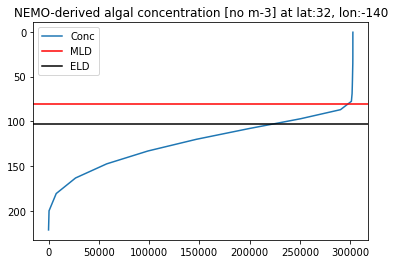

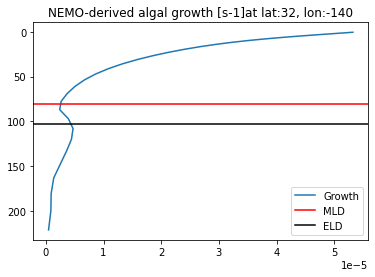

In [41]:
pfile = xr.open_dataset('/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/ORCA0083-N06_20070105d05P.nc')
ppfile = xr.open_dataset('/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/ORCA0083-N06_20070105d05D.nc')
tsfile = xr.open_dataset('/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/ORCA0083-N06_20070105d05T.nc')

d_phy_or = pfile.variables['PHD']
#nd_phy_or = pfile.variables['PHN']
tpp3_or = ppfile.variables['TPP3']
mld_or = tsfile.variables['mldr10_1']
eld_or = ppfile.variables['MED_XZE']

d_phy = d_phy_or[:,:,iy,ix].data            
#nd_phy = nd_phy_or[:,:,iy,ix].data
tpp3 = tpp3_or[:,:,iy,ix].data
mld = mld_or[:,iy,ix].data
eld = eld_or[:,iy,ix].data

#------ Nitrogen to cell ratios for ambient algal concentrations ('aa') and algal growth ('mu_aa') from NEMO output (no longer using N:C:AA (Redfield ratio), directly N:AA from Menden-Deuer and Lessard 2000)     
med_N2cell = 356.04e-09 #[mgN cell-1] median value is used below (as done in Kooi et al. 2017)

#------ Ambient algal concentration from MEDUSA's non-diatom + diatom phytoplankton 
n0 = d_phy                 # [mmol N m-3] in MEDUSA
n = n0*14.007                       # conversion from [mmol N m-3] to [mg N m-3] (atomic weight of 1 mol of N = 14.007 g)   
n2 = n/med_N2cell                   # conversion from [mg N m-3] to [no. m-3]

# if n2<0.: 
#     aa = 0.
# else:
aa = n2
    
#------ Primary productivity (algal growth) from MEDUSA TPP3 (no longer condition of only above euphotic zone, since not much diff in results)
tpp0 = tpp3              # [mmol N m-3 d-1]
mu_n0 = tpp0*14.007               # conversion from [mmol N m-3 d-1] to [mg N m-3 d-1] (atomic weight of 1 mol of N = 14.007 g) 
mu_n = mu_n0/med_N2cell           # conversion from [mg N m-3 d-1] to [no. m-3 d-1]
mu_n2 = mu_n/aa                   # conversion from [no. m-3 d-1] to [d-1]

#mu_aa = mu_n2/86400.
#print(mu_aa)

# if mu_n2<0.:
#     mu_aa = 0.
# else:
mu_aa = mu_n2/86400.          # conversion from d-1 to s-1

plt.figure(1)
plt.plot(aa.T[0:32],Depth[0:32],label = 'Conc')
plt.axhline(y = mld, color = 'r', linestyle = '-',label='MLD') #plt.plot(mld[0])
plt.axhline(y = eld, color = 'k', linestyle = '-',label='ELD')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f'NEMO-derived algal concentration [no m-3] at lat:{minlat}, lon:{minlon}')


plt.figure(2)
plt.plot(mu_aa.T[0:32],Depth[0:32],label = 'Growth')
plt.axhline(y = mld, color = 'r', linestyle = '-',label='MLD') #plt.plot(mld[0])
plt.axhline(y = eld, color = 'k', linestyle = '-',label='ELD')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f'NEMO-derived algal growth [s-1]at lat:{minlat}, lon:{minlon}')

In [16]:
print(mld[0])

[93.58247 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247
 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247
 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247 93.58247
 93.58247 93.58247 93.58247 93.58247]


5017783.1576784095
2.0883554551638747e-05


Text(0.5, 1.0, 'Kooi-derived algal growth [s-1]')

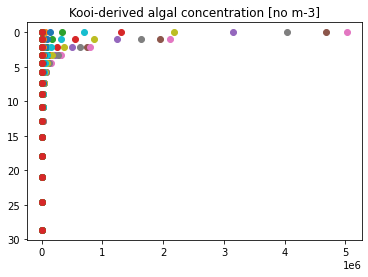

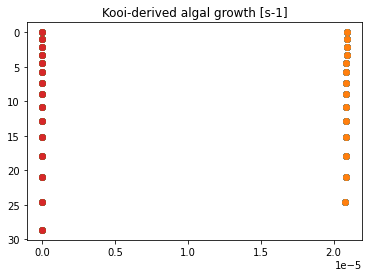

In [11]:
# 06/08/20- comparing the order of magnitude from NEMO to Kooi data (checking again)

with open('/home/dlobelle/Kooi_data/data_input/profiles_t.pickle', 'rb') as p:
    depth,time,A_A_t,mu_A_t = pickle.load(p)

mu_A_t = mu_A_t/86400.    
    
hours = 24    
for tt in range (0,hours):
    plt.figure(1)
    plt.scatter(A_A_t[tt,0:15],depth[0:15])
    
    plt.figure(2)
    plt.scatter(mu_A_t[tt,0:15],depth[0:15])

print(np.max(A_A_t))
print(np.max(mu_A_t))
    
plt.figure(1)
plt.gca().invert_yaxis()
plt.title('Kooi-derived algal concentration [no m-3]')

plt.figure(2)
plt.gca().invert_yaxis()
plt.title('Kooi-derived algal growth [s-1]')